# Cookbook for CREST files preparation
Step by step manual for CREST input files preparation.

## 1 Basic Folder
This folder contains the raster files that represent the geographic information of the basin and a text file that defines the average height difference. 

Files in the basic folder are: 
- /basic
    - dem.tif
    - fdr.tif
    - fac.tif
    - stream.tif
    - refMask.tif
    - slope.def

### 1.1 Parameters
Two parameters are needed, the coordinates of:
1. Approximate basin geoextent
2. outlet point

In [5]:
crop_extent = (-73.75, 42.55, -71.85, 41.10)  # Specify the geographic extent in (left, top, right, bottom) format
x, y = -73.06034, 41.43952 # Specify the location of the center point in (longitude, latitude) format

### 1.2 Download DEM
https://data.hydrosheds.org/file/hydrosheds-v1-dem/hyd_na_dem_15s.zip

### 1.3 DEM preprocess
Crop the DEM based on user provided geoextent: crop_extent

In [27]:
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import from_origin

# Import plot modules
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
import numpy as np

input_file = '/Users/qyang/Downloads/data/CREST/Demo_case/hyd_na_dem_15s/hyd_na_dem_15s.tif' # unzipped dem file
output_file = '/Users/qyang/Downloads/data/CREST/Demo_case/hyd_na_dem_15s/hyd_na_dem_15s_setnan_cropped.tif'
desired_nodata = -32768

# Read the raster file
with rasterio.open(input_file) as src:
    # Get the geospatial information
    transform = src.transform
    crs = src.crs
    nodata = src.nodata

    # Determine the window to crop
    left, top, right, bottom = crop_extent
    row_start, col_start = src.index(left, top)
    row_stop, col_stop = src.index(right, bottom)
    window = rasterio.windows.Window(col_start, row_start, col_stop - col_start, row_stop - row_start)

    # Calculate the new transform for the cropped area
    crop_transform = from_origin(transform[0] * window.col_off + transform[2], transform[4] * window.row_off + transform[5],
                                 transform[0], -transform[4])  # Note the negative sign

    # Read the cropped data
    data = src.read(1, window=window)

    # Modify the nodata value
    data[data == nodata] = desired_nodata

    # Update the metadata with the new nodata value and transform
    profile = src.profile
    profile.update(nodata=desired_nodata, transform=crop_transform, height=data.shape[0], width=data.shape[1])

    # Write the cropped and modified data to a new file
    with rasterio.open(output_file, 'w', **profile) as dst:
        dst.write(data, 1)


### 1.4 FDR FAC generation


In [29]:
# Read DEM raster
# ----------------------------
grid = Grid.from_raster(output_file)
dem = grid.read_raster(output_file)

# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)
# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Determine D8 flow directions from DEM
# ----------------------
# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
# -------------------------------------
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)

# Calculate flow accumulation
# --------------------------
acc = grid.accumulation(fdir, dirmap=dirmap)

# Option: Export the flow accumulation to a raster file, check the outlet location in QGIS/ArGIS
# --------------------------
#output_file = '/Users/qyang/Downloads/data/CREST/Demo_case/hyd_na_dem_15s/cropped_acc.tif'
#grid.to_raster(acc, output_file)

### 1.5 Basin generation
Generate a basin mask based on the outlet point and the FDR


In [49]:
# Delineate the catchment with outlet
# --------------------------
# Reset the view
grid.viewfinder = fdir.viewfinder

# Option 1: Specify outlet point with longitude and latitude
x, y = -73.06034, 41.43952 # USGS site 01208500 Naugatuck River
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

# Option 2: Specify outlet point with row and column index on accumulation file
#col, row = 166, 266
# Delineate the catchment
#catch = grid.catchment(x=col, y=row, fdir=fdir, xytype='index')

# Plot the result
grid.clip_to(catch)
catch_view = grid.view(catch)

Text(0.5, 1.0, 'Delineated Catchment')

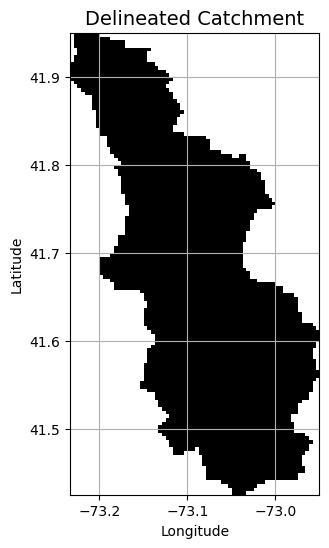

In [50]:
# Plot the catchment
# --------------------------
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(catch_view, catch_view, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

### 1.6 Basic file clip and export

In [72]:
# clip dem, fdir, acc to catchment
# --------------------------
dem_basic = grid.view(dem, nodata=np.nan)
fdr_basic = grid.view(fdir, nodata=np.nan)
fac_basic = grid.view(acc, nodata=np.nan)

# get stream with threshold 96
# --------------------------
stream_basic = np.where(fac_basic >= 96, 1, np.nan)

# get refMask (pixel id mask)
# --------------------------
# Count the number of non-NaN pixels in the catchment
n = np.count_nonzero(~np.isnan(dem_basic))
# Create a new raster with the same shape as dem_basic
refMask = np.zeros_like(dem_basic)
# Assign values from 1 to n to non-NaN pixels
refMask[~np.isnan(dem_basic)] = range(1, n + 1)
refMask = np.where(refMask >= 1, refMask, np.nan)



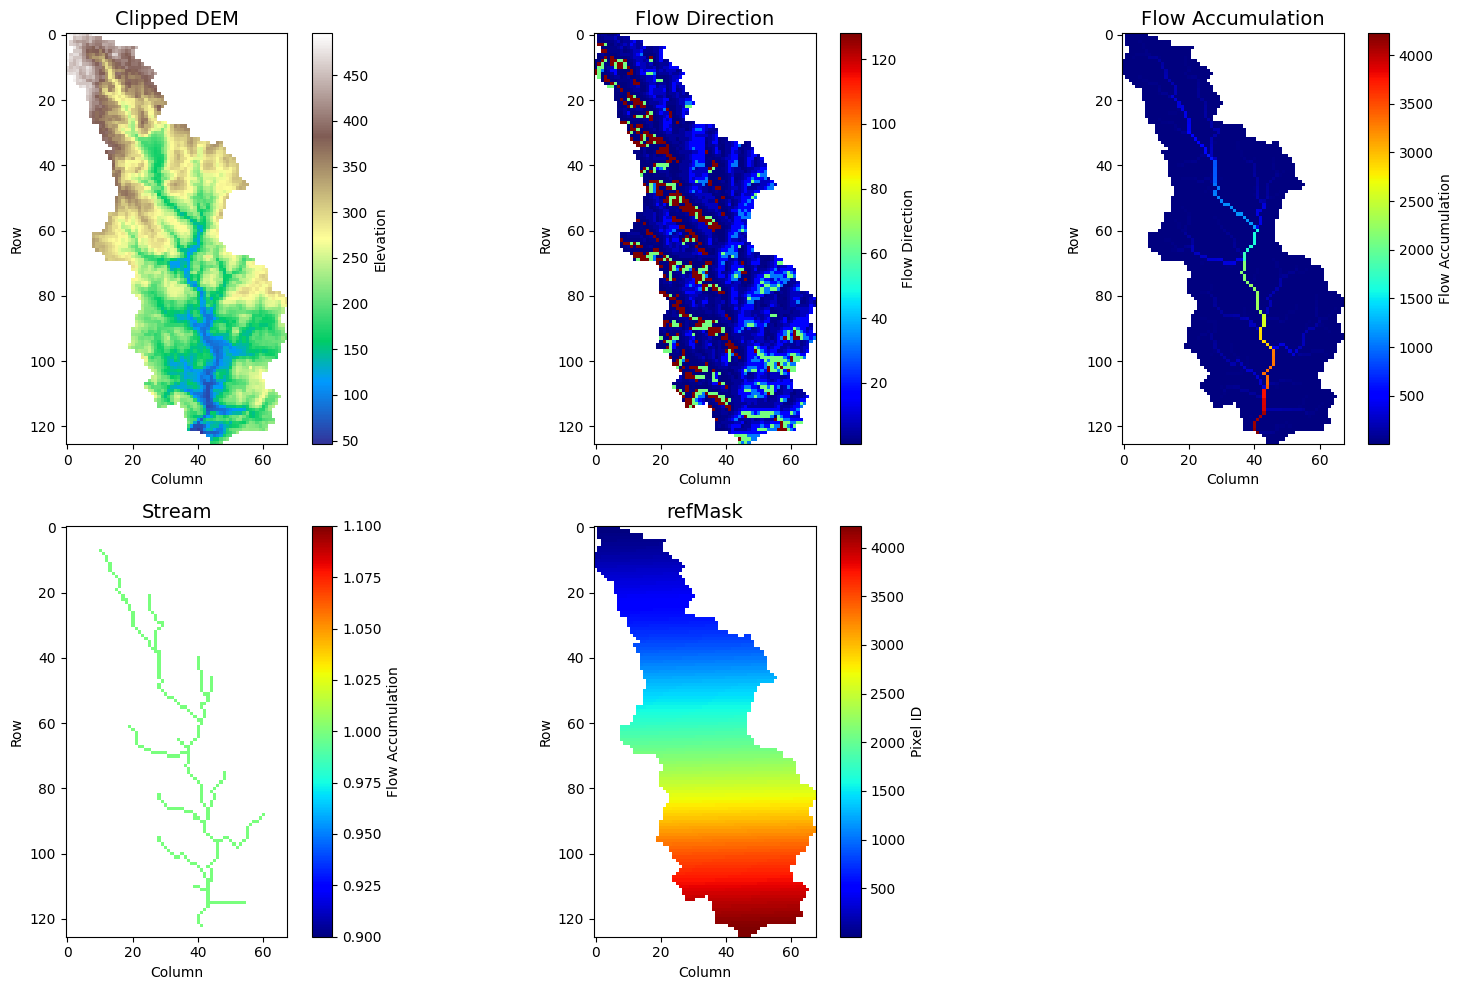

In [74]:
#review the clip results
# Create the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(16, 10))
fig.patch.set_alpha(0)

# Plot dem_basic
im1 = axs[0, 0].imshow(dem_basic, cmap='terrain')
axs[0, 0].set_title('Clipped DEM', size=14)
axs[0, 0].set_xlabel('Column')
axs[0, 0].set_ylabel('Row')
fig.colorbar(im1, ax=axs[0, 0], label='Elevation')

# Plot fdr_basic
im2 = axs[0, 1].imshow(fdr_basic, cmap='jet')
axs[0, 1].set_title('Flow Direction', size=14)
axs[0, 1].set_xlabel('Column')
axs[0, 1].set_ylabel('Row')
fig.colorbar(im2, ax=axs[0, 1], label='Flow Direction')

# Plot fac_basic
im3 = axs[0, 2].imshow(fac_basic, cmap='jet')
axs[0, 2].set_title('Flow Accumulation', size=14)
axs[0, 2].set_xlabel('Column')
axs[0, 2].set_ylabel('Row')
fig.colorbar(im3, ax=axs[0, 2], label='Flow Accumulation')

# Plot stream_basic
im4 = axs[1, 0].imshow(stream_basic, cmap='jet')
axs[1, 0].set_title('Stream', size=14)
axs[1, 0].set_xlabel('Column')
axs[1, 0].set_ylabel('Row')
fig.colorbar(im4, ax=axs[1, 0], label='Flow Accumulation')

# Plot refMask
im5 = axs[1, 1].imshow(refMask, cmap='jet')
axs[1, 1].set_title('refMask', size=14)
axs[1, 1].set_xlabel('Column')
axs[1, 1].set_ylabel('Row')
fig.colorbar(im5, ax=axs[1, 1], label='Pixel ID')

# Remove empty subplot
fig.delaxes(axs[1, 2])

# Adjust the layout
plt.tight_layout()

# Show the figure
plt.show()


In [76]:
# Export the basic rasters to GeoTiff
# --------------------------
import os
output_folder = '/Users/qyang/Downloads/data/CREST/Demo_case/basic' # User specified folder
output_files = ['dem.tif', 'fdr.tif', 'fac.tif']
rasters = [dem_basic, fdr_basic, fac_basic]

for file, raster in zip(output_files, rasters):
    output_path = os.path.join(output_folder, file)
    grid.to_raster(raster, output_path)

# Read the fac.tif file
with rasterio.open(output_folder+'/dem.tif') as src:
    # Read the data and metadata
    fac_data = src.read(1)
    profile = src.profile

# Update the profile metadata for the new rasters
profile.update(
    dtype=rasterio.float32,  # Change the data type if necessary
    nodata=np.nan,  # Set the nodata value
    count=1  # Set the number of bands
)

# Write stream.tif
with rasterio.open(output_folder+'/stream.tif', 'w', **profile) as dst:
    dst.write(stream_basic, 1)

# Write refMask.tif
with rasterio.open(output_folder+'/refMask.tif', 'w', **profile) as dst:
    dst.write(refMask, 1)

## 2 Param Folder
This folder contains the raster files of different soil type, land cover and impervious surface. Also contains one .csv file of the coverlib and one .txt file for model landsurface and routing parameters

Files inside param folder are: 
- /param
    - BLD_sd1.tif
    - BLD_sd2.tif
    - BLD_sd3.tif
    - BLD_sd4.tif
    - BLD_sd5.tif
    - BLD_sd6.tif
    - CLYPPT_sd1.tif
    - CLYPPT_sd2.tif
    - CLYPPT_sd3.tif
    - CLYPPT_sd4.tif
    - CLYPPT_sd5.tif
    - CLYPPT_sd6.tif
    - FC_sd1.tif
    - FC_sd2.tif
    - FC_sd3.tif
    - FC_sd4.tif
    - FC_sd5.tif
    - FC_sd6.tif
    - KSAT_sd1.tif
    - KSAT_sd2.tif
    - KSAT_sd3.tif
    - KSAT_sd4.tif
    - KSAT_sd5.tif
    - KSAT_sd6.tif
    - Lambda_sd1.tif
    - Lambda_sd2.tif
    - Lambda_sd3.tif
    - Lambda_sd4.tif
    - Lambda_sd5.tif
    - Lambda_sd6.tif
    - ORCDRC_sd1.tif
    - ORCDRC_sd2.tif
    - ORCDRC_sd3.tif
    - ORCDRC_sd4.tif
    - ORCDRC_sd5.tif
    - ORCDRC_sd6.tif
    - SAT_sd1.tif
    - SAT_sd2.tif
    - SAT_sd3.tif
    - SAT_sd4.tif
    - SAT_sd5.tif
    - SAT_sd6.tif
    - SNDPPT_sd1.tif
    - SNDPPT_sd2.tif
    - SNDPPT_sd3.tif
    - SNDPPT_sd4.tif
    - SNDPPT_sd5.tif
    - SNDPPT_sd6.tif
    - Wwp_sd1.tif
    - Wwp_sd2.tif
    - Wwp_sd3.tif
    - Wwp_sd4.tif
    - Wwp_sd5.tif
    - Wwp_sd6.tif
    - LCC.tif
    - IM.tif
    - CoverLib.csv
    - parameters.txt

### 2.1 Environment
Run the following command in the terminal:

```shell
pip install soilgrids

### 2.2 Download soilgrids data

In [11]:
import rasterio
from rasterio.warp import transform_bounds
import pyproj
from soilgrids import SoilGrids


# Specify the path to the raster file
file_path = '/Users/qyang/Downloads/data/CREST/Demo_case/basic/dem.tif'
# Define the target CRS as EPSG:3857
target_crs = pyproj.CRS.from_epsg(3857)
# Read the raster file
with rasterio.open(file_path) as src:
    # Get the bounds in the original CRS
    bounds = src.bounds
    # Transform the bounds to EPSG:3857 CRS
    transformed_bounds = transform_bounds(src.crs, target_crs, *bounds)
# Print the transformed bounds
print(transformed_bounds)

# Specify the download path
out_folder = '/Users/qyang/Downloads/data/CREST/Demo_case/SoilGrids'
# Choose the soil property
ser_ids = ['sand','clay','silt','soc','bdod']
layers = ['0-5cm','5-15cm','15-30cm','30-60cm','60-100cm','100-200cm']
soil_grids = SoilGrids()

west, south, east, north = transformed_bounds[0], transformed_bounds[1], transformed_bounds[2], transformed_bounds[3]
for isid in ser_ids:
    for lyrs in layers:
        tcver_id =isid+'_'+lyrs+'_mean'
        print(tcver_id)               
        data = soil_grids.get_coverage_data(service_id=isid, coverage_id=tcver_id, 
                                        west=west, south=south, east=east, north=north,
                                        crs='urn:ogc:def:crs:EPSG::3857',
                                        output=os.path.join(out_folder, tcver_id+'.tif'))


(-8152297.37576073, 5075232.6255785115, -8120756.853369303, 5153492.62658819)
sand_0-5cm_mean
sand_5-15cm_mean
sand_15-30cm_mean
sand_30-60cm_mean
sand_60-100cm_mean
sand_100-200cm_mean
clay_0-5cm_mean
clay_5-15cm_mean
clay_15-30cm_mean
clay_30-60cm_mean
clay_60-100cm_mean
clay_100-200cm_mean
silt_0-5cm_mean
silt_5-15cm_mean
silt_15-30cm_mean
silt_30-60cm_mean
silt_60-100cm_mean
silt_100-200cm_mean
soc_0-5cm_mean
soc_5-15cm_mean
soc_15-30cm_mean
soc_30-60cm_mean
soc_60-100cm_mean
soc_100-200cm_mean
bdod_0-5cm_mean
bdod_5-15cm_mean
bdod_15-30cm_mean
bdod_30-60cm_mean
bdod_60-100cm_mean
bdod_100-200cm_mean


### 2.2 Interpolate soilgrids to soil properties files

In [86]:
import os
import glob
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling

param_output_folder = '/Users/qyang/Downloads/data/CREST/Demo_case/Param/cropped'
os.makedirs(param_output_folder, exist_ok=True)

# Open the DEM.tif file
with rasterio.open('/Users/qyang/Downloads/data/CREST/Demo_case/basic/dem.tif') as dem:
    bounds = dem.bounds
    geoms = [{"type": "Polygon", "coordinates": [[
        [bounds.left, bounds.bottom],
        [bounds.left, bounds.top],
        [bounds.right, bounds.top],
        [bounds.right, bounds.bottom],
        [bounds.left, bounds.bottom]
    ]]}]
    dem_meta = dem.meta

# Get the list of all GeoTIFF files in the specified directory
tif_files = glob.glob('/Users/qyang/Downloads/data/CREST/Demo_case/Param/*.tif')

# Process each file
for tif_file in tif_files:
    # Read the GeoTIFF file
    with rasterio.open(tif_file) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()

        # Match the size with dem.tif
        destination = np.zeros((dem_meta['count'], dem_meta['height'], dem_meta['width']), np.float32)
        reproject(
            out_image,
            destination,
            src_transform=out_transform,
            src_crs=out_meta['crs'],
            dst_transform=dem_meta['transform'],
            dst_crs=dem_meta['crs'],
            resampling=Resampling.bilinear
        )
        out_image = destination
        out_transform = dem_meta['transform']

    # Update the metadata with new dimensions, transform (affine) and CRS (coordinate reference system)
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    # Write the cropped raster to a new file
    with rasterio.open(os.path.join(param_output_folder, os.path.basename(tif_file)), "w", **out_meta) as dest:
        dest.write(out_image)


## 3 Forcing Data

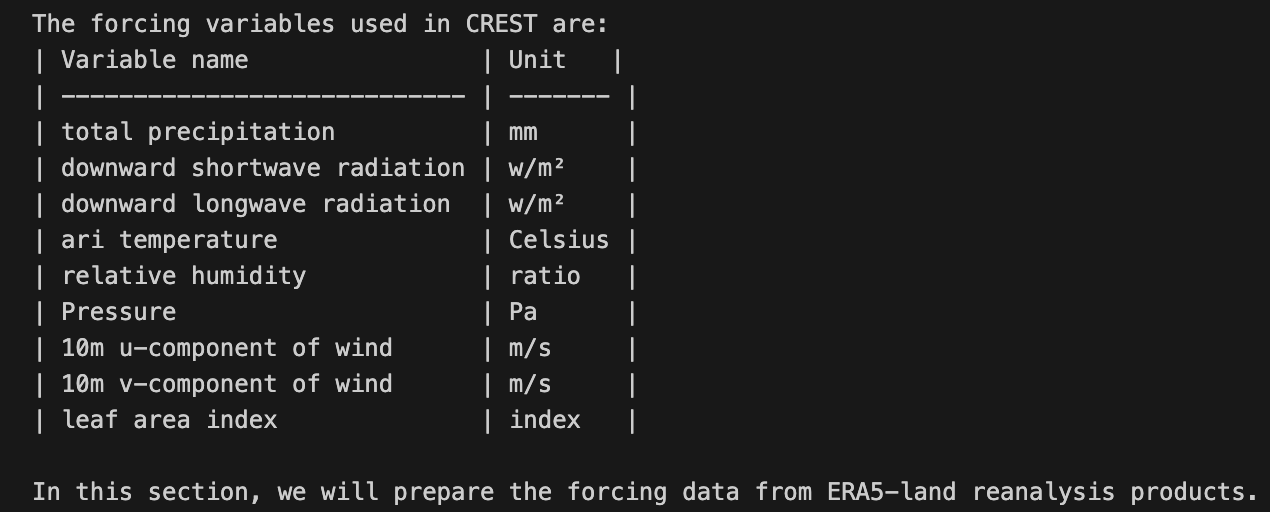

The forcing variables used in CREST are:
| Variable name                | Unit   |
| ---------------------------- | ------- |
| total precipitation          | mm      |
| downward shortwave radiation | w/m²    |
| downward longwave radiation  | w/m²    |
| ari temperature              | Celsius |
| relative humidity            | ratio   |
| Pressure                     | Pa      |
| 10m u-component of wind      | m/s     |
| 10m v-component of wind      | m/s     |
| leaf area index              | index   |

In this section, we will prepare the forcing data from ERA5-land reanalysis products.

## 3.1 Environment
Run the following command in the terminal:

```shell
pip install cdsapi
conda install xarray cfgrib -c conda-forge


## 3.2 Download forcing from ERA5-Land

Data source:
- [Reanalysis ERA5-Land](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview)

API key set up:
- [CDS API How-to](https://cds.climate.copernicus.eu/api-how-to)


In [12]:
crop_extent = (-73.75, 42.55, -71.85, 41.10)  # Specify the geographic extent in (left, top, right, bottom) format
ERA5_download_file = '/Users/qyang/Downloads/data/CREST/Demo_case/ERA5.grib' # Specify the download file path

import cdsapi
import warnings
# disable warnings
warnings.filterwarnings("ignore")


c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            '2m_temperature', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation',
            'surface_pressure', 'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards',
            'total_precipitation',
        ],
        'area': [
            crop_extent[1], crop_extent[0], crop_extent[3], crop_extent[2],
        ],
        'format': 'grib',
        'year': '2015',
        'month': '08',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30','31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
    },
    ERA5_download_file) 

2023-07-09 21:43:03,152 INFO Welcome to the CDS
INFO:cdsapi:Welcome to the CDS
2023-07-09 21:43:03,153 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
INFO:cdsapi:Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land
2023-07-09 21:43:03,447 INFO Request is completed
INFO:cdsapi:Request is completed
2023-07-09 21:43:03,448 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data1/adaptor.mars.internal-1688871478.8606374-25388-6-9050b884-3132-4670-b83e-89766d533f22.grib to /Users/qyang/Downloads/data/CREST/Demo_case/ERA5.grib (185.6K)
INFO:cdsapi:Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data1/adaptor.mars.internal-1688871478.8606374-25388-6-9050b884-3132-4670-b83e-89766d533f22.grib to /Users/qyang/Downloads/data/CREST/Demo_case/ERA5.grib (185.6K)
2023-07-09 21:43:05,620 INFO Download rate 85.5K/s 
INFO:cdsapi:Download rate 85.5K/s


Result(content_length=190080,content_type=application/x-grib,location=https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data1/adaptor.mars.internal-1688871478.8606374-25388-6-9050b884-3132-4670-b83e-89766d533f22.grib)

## 3.3 ERA5 forcing preprocess

In [13]:
import os
import xarray as xr
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import numpy as np

file = ERA5_download_file
out_dir = '/Users/qyang/Downloads/data/CREST/Demo_case/ERA5' # Specify the forcing files directory
os.makedirs(out_dir, exist_ok=True)

ds = xr.open_dataset(file, engine='cfgrib')
    
# Constants
Rdry = 287.0597
Rvap = 461.5250
a1 = 611.21
a3 = 17.502
a4 = 32.19
T0 = 273.16

# Loop through each time step and forecast step
for time in ds.time.values:
    for idx, step in enumerate(ds.step.values):
        # Select the data for this time step and forecast step
        ds_timestep = ds.sel(time=time, step=step)
        
        # Format the time as a string
        valid_time = pd.to_datetime(time + step)
        valid_time_str = valid_time.strftime('%Y-%m-%d_%H%M%S')
        
        # Compute hourly_tp value
        try:
            if idx > 0:
                previous_step = ds.step.values[idx-1]
                previous_ds_timestep = ds.sel(time=time, step=previous_step)
                previous_hour_tp = previous_ds_timestep['tp'].values
                hourly_tp = ds_timestep['tp'].values - previous_hour_tp
            else:
                hourly_tp = ds_timestep['tp'].values
        except KeyError:
            hourly_tp = ds_timestep['tp'].values
        hourly_tp *= 1000  # Convert meters to millimeters
        hourly_tp = np.clip(hourly_tp, 0, None)  # Set negative values to zero
        
        # Divide ssrd and strd by the number of seconds in each time step
        seconds_in_step = np.timedelta64(step, 's').astype(int)
        hourly_ssrd = ds_timestep['ssrd'].values / seconds_in_step
        hourly_strd = ds_timestep['strd'].values / seconds_in_step
        
        # Compute relative humidity
        dtas = ds_timestep['d2m'].values  # Convert dewpoint temperature to Celsius
        ps = ds_timestep['sp'].values  # Convert surface pressure to hPa
        
        # credit to https://confluence.ecmwf.int/pages/viewpage.action?pageId=171411214
        # Compute saturation water vapor pressure (E)
        E = a1 * np.exp(a3 * (dtas - T0) / (dtas - a4))
        # Compute saturation specific humidity
        relative_humidity = (Rdry / Rvap) * E / (ps - ((1 - Rdry / Rvap) * E))
        
        # Compute surface temperature in Celsius
        surface_temperature = ds_timestep['t2m'].values - 273.16
        
        # Compute total LAI
        lai_hv = ds_timestep['lai_hv'].values
        lai_lv = ds_timestep['lai_lv'].values
        total_lai = lai_hv + lai_lv
        
        # GeoTiff meta data
        # Get the minimum and maximum longitude and latitude values
        lon_min = ds_timestep.longitude.min().values
        lat_min = ds_timestep.latitude.min().values
        lon_max = ds_timestep.longitude.max().values
        lat_max = ds_timestep.latitude.max().values

        # Compute the number of pixels in x and y directions
        width = len(ds_timestep.longitude)
        height = len(ds_timestep.latitude)

        # Create the transform using from_bounds()
        transform = rasterio.transform.from_bounds(lon_min, lat_min, lon_max, lat_max, width, height)

        meta = {
            'driver': 'GTiff',
            'dtype': 'float32',
            'nodata': None,
            'width': len(ds_timestep.longitude),
            'height': len(ds_timestep.latitude),
            'count': len(ds_timestep.data_vars) + 6,  # Add 6 for hourly_tp, hourly_ssrd, hourly_strd, relative_humidity, surface_temperature, and total_lai bands
            'crs': rasterio.crs.CRS.from_string('EPSG:4326'),  # WGS84
            'transform': transform,
            'compress': 'lzw',
        }
        
        # File name for this time step
        file_name = f'ERA5_{valid_time_str}.tif'
        out_file = os.path.join(out_dir, file_name)
        
        # Save the data for this time step as a new GeoTiff file
        with rasterio.open(out_file, 'w', **meta) as dst:
            # Write hourly_tp band
            dst.write(hourly_tp, len(ds_timestep.data_vars) + 1)
            dst.set_band_description(len(ds_timestep.data_vars) + 1, 'hourly_tp')
            
            # Write hourly_ssrd band
            dst.write(hourly_ssrd, len(ds_timestep.data_vars) + 2)
            dst.set_band_description(len(ds_timestep.data_vars) + 2, 'hourly_ssrd')
            
            # Write hourly_strd band
            dst.write(hourly_strd, len(ds_timestep.data_vars) + 3)
            dst.set_band_description(len(ds_timestep.data_vars) + 3, 'hourly_strd')
            
            # Write relative_humidity band
            dst.write(relative_humidity, len(ds_timestep.data_vars) + 4)
            dst.set_band_description(len(ds_timestep.data_vars) + 4, 'relative_humidity')
            
            # Write surface_temperature band
            dst.write(surface_temperature, len(ds_timestep.data_vars) + 5)
            dst.set_band_description(len(ds_timestep.data_vars) + 5, 'surface_temperature')
            
            # Write total_lai band
            dst.write(total_lai, len(ds_timestep.data_vars) + 6)
            dst.set_band_description(len(ds_timestep.data_vars) + 6, 'total_lai')
            
            # Write other bands
            for i, var in enumerate(ds_timestep.data_vars, start=1):
                data = ds_timestep[var].values
                dst.write(data, i)
                dst.set_band_description(i, var)
